# Search Engines Market Analysis

In [1]:
%matplotlib inline

import sys
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from itertools import product
from dateutil.parser import parse
from datetime import date, timedelta
from rpy2.robjects import r, pandas2ri as pd2

pd2.activate()

plt.style.use('bmh')
plt.rcParams['figure.figsize'] = (16, 8)

sys.path.extend(['./forecast-master', './forecast-master/forecast'])
from forecast import forecast, stl, stldf, bind

## Data Reading

* `date` - дата по дням с 2014-01-01 до 2017-09-28 включительно
* `se` - поисковая система, либо yandex либо search
* `browser` - браузер, 5 типов
* `hits` - ...

In [2]:
df = pd.read_csv('raw_data.csv')
df.isnull().values.any()  # Check if df has nan values.

False

In [3]:
df.head()

,date,se,browser,hits
0,2014-01-01,search,chrome,44778823.0
1,2014-01-01,yandex,chrome,16237589.0
2,2014-01-02,search,chrome,52448725.0
3,2014-01-02,yandex,chrome,18979110.0
4,2014-01-03,search,chrome,54640145.0


In [4]:
df.tail()

,date,se,browser,hits
13625,2017-09-26,yandex,yabrowser,11411354.0
13626,2017-09-27,search,yabrowser,11992743.0
13627,2017-09-27,yandex,yabrowser,11385000.0
13628,2017-09-28,search,yabrowser,11670090.0
13629,2017-09-28,yandex,yabrowser,11082319.0


In [5]:
FIRST_DAY, LAST_DAY = parse(df.date[0]), parse(df.date.iloc[-1])
FIRST_DAY, LAST_DAY

(datetime.datetime(2014, 1, 1, 0, 0), datetime.datetime(2017, 9, 28, 0, 0))

In [6]:
df.describe()

,hits
count,1.363000e+04
mean,1.382602e+07
std,1.192289e+07
min,0.000000e+00
25%,6.900053e+06
50%,1.148853e+07
75%,1.554847e+07
max,6.667708e+07


In [7]:
SES, BROWSERS = np.unique(df['se']).tolist(), np.unique(df['browser']).tolist()
SES, BROWSERS

(['search', 'yandex'], ['chrome', 'firefox', 'msie', 'opera', 'yabrowser'])

## Data Prerocessing

Устраняем аномалии в данных.

### Дополним недостающие данные

Заметим, что дней с первого до последнего рассматриваемого дня:

In [8]:
(LAST_DAY - FIRST_DAY).days + 1

1367

А в датасета на каждую из 10 пар se, brower есть:

In [9]:
df.groupby(['se', 'browser']).size()

se      browser  
search  chrome       1363
        firefox      1363
        msie         1363
        opera        1363
        yabrowser    1363
yandex  chrome       1363
        firefox      1363
        msie         1363
        opera        1363
        yabrowser    1363
dtype: int64

Пропущенные значение - 4 дня от 2014-12-28 до 2014-12-31, пока восстановим их нулями.

In [10]:
missing_dates = ['2014-12-28', '2014-12-29', '2014-12-30', '2014-12-31']
for date, se, browser in product(missing_dates, SES, BROWSERS):
    df = df.append({'date': date, 'se': se, 'browser': browser, 'hits': 0.0}, ignore_index=True)

df.date = df.date.astype('datetime64[ns]')
df.sort_values(['date', 'se', 'browser'], inplace=True)
df.reset_index(drop=True, inplace=True)

Продолжим разбираться с данными.

In [11]:
def plot_pivot(df_to_plot, columns, *, title=None):
    data_args = {'index': 'date', 'values': 'hits', 
                 'columns': columns, 'aggfunc': np.sum}
    plot_args = {'title': title or f'{columns} pivot'}
    df_to_plot.pivot_table(**data_args).plot(**plot_args)


def plot_fix(fix, df_to_plot, columns):
    plot_pivot(df_to_plot, columns, title=f'before {fix.__name__}')
    plot_pivot(fix(df_to_plot), columns, title=f'after {fix.__name__}')

### Разрез `se`

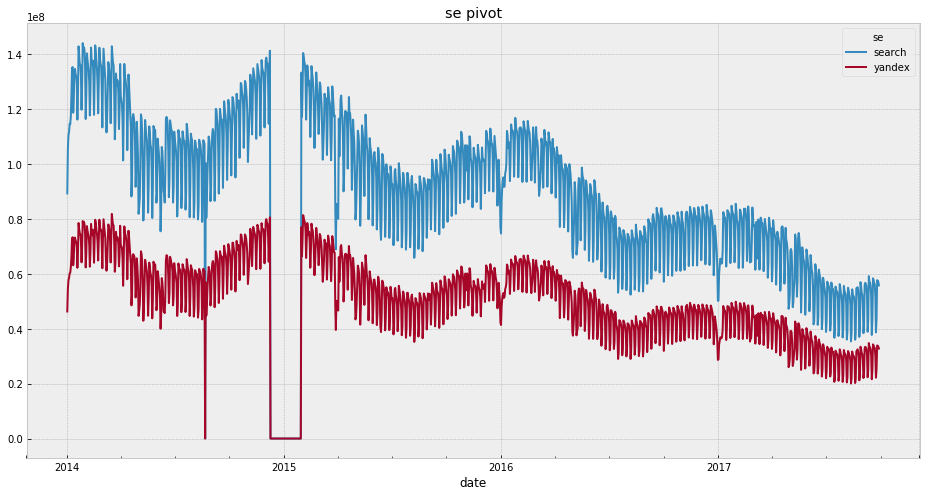

In [12]:
plot_pivot(df, 'se')

Что можно заметить?  
Во-первых, первые пару дней в январе 2014 аномально маленькие (хоть это и новогодние праздники, но в других годах падение не такое существенное). Посмотрим поближе.

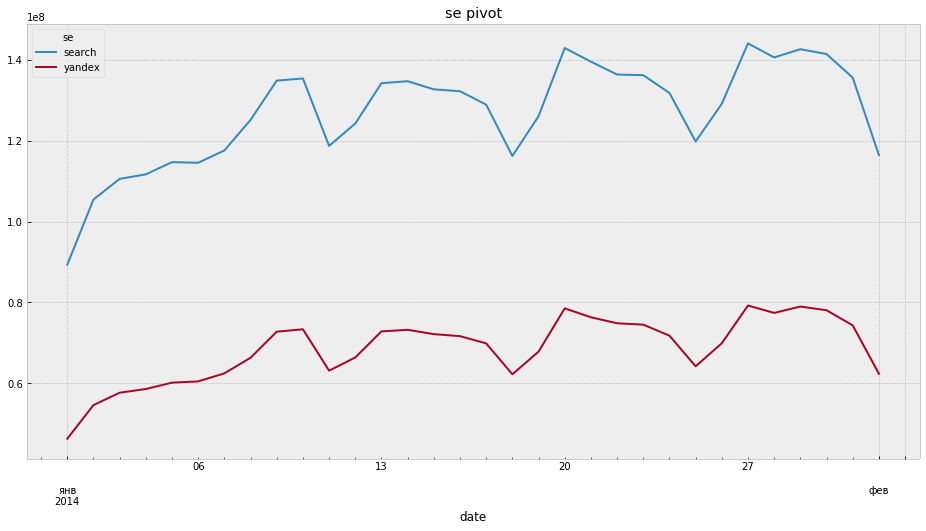

In [13]:
plot_pivot(df[df.date <= '2014-02-01'], 'se')

Видно, что можем отрезать префикм до 9-го числа.

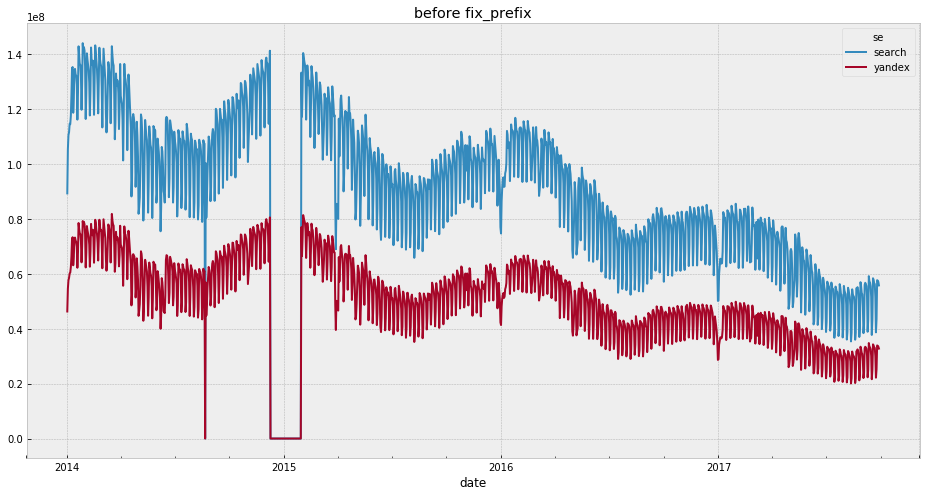

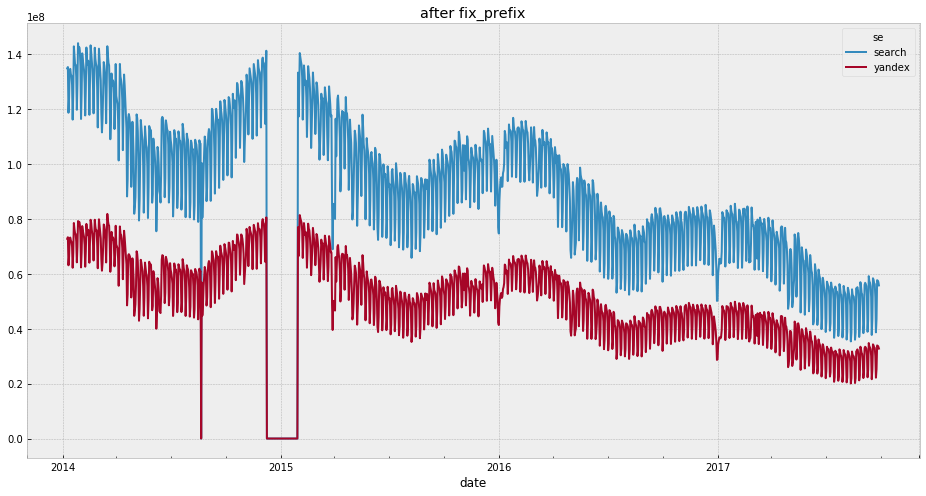

In [14]:
def fix_prefix(df): return df[df.date >= '2014-01-09']
plot_fix(fix_prefix, df, 'se')

In [15]:
df = fix_prefix(df)

Теперь посмотрим на аномальное низкие показатели в районе 2014-09, новый год 15-го и в районе 2015-03-15.

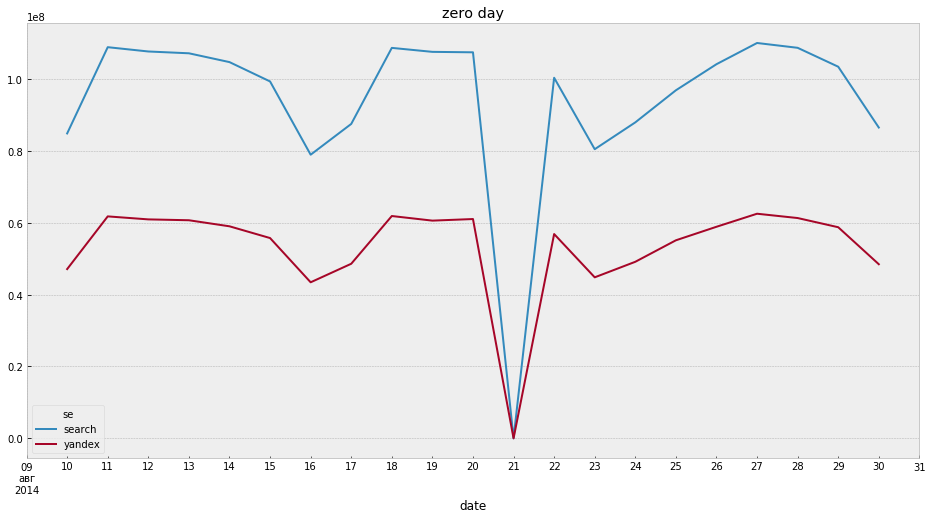

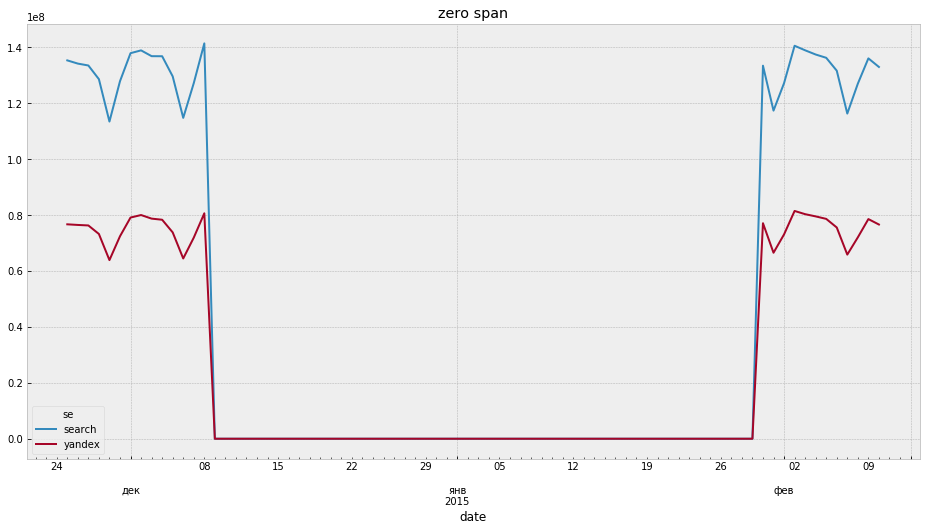

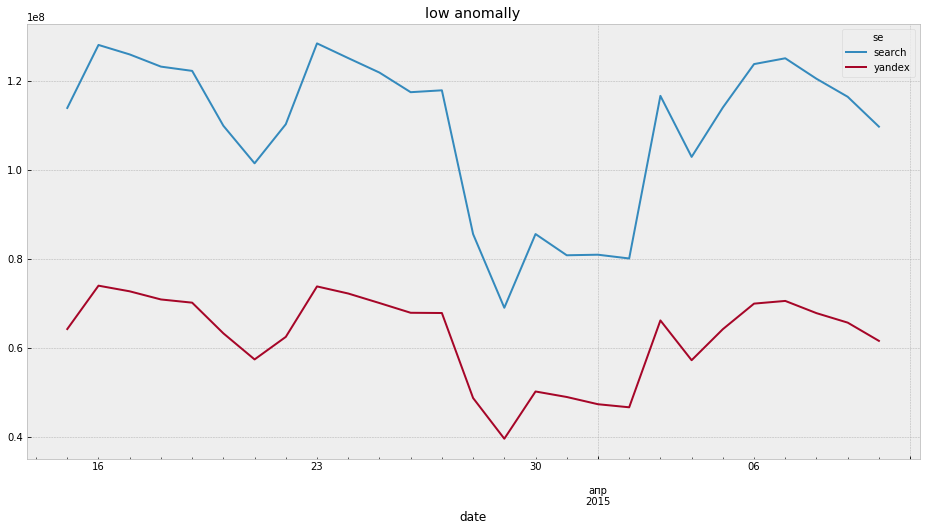

In [16]:
plot_pivot(df[('2014-08-10' <= df.date) & (df.date <= '2014-08-30')], 'se', title='zero day')
plot_pivot(df[('2014-11-25' <= df.date) & (df.date <= '2015-02-10')], 'se', title='zero span')
plot_pivot(df[('2015-03-15' <= df.date) & (df.date <= '2015-04-10')], 'se', title='low anomally')

Зафиксируем промежутки (значение подберем эмпирически - так быстрее).

In [17]:
ZDAY = '2014-08-21'
ZSPAN = '2014-12-09', '2015-01-29'
LSPAN = '2015-03-27', '2015-04-04'

Напишем фикс.  
Для нулевого дня возьмем среднее ближайших, для нулевого промежутка - перенесем и отскалируем со следующего года.  
Для спайка перенесем со следующей недели.

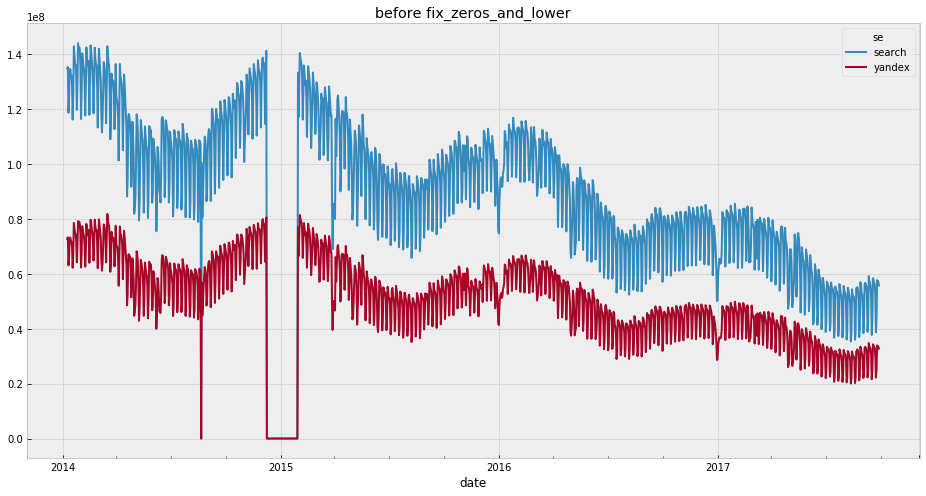

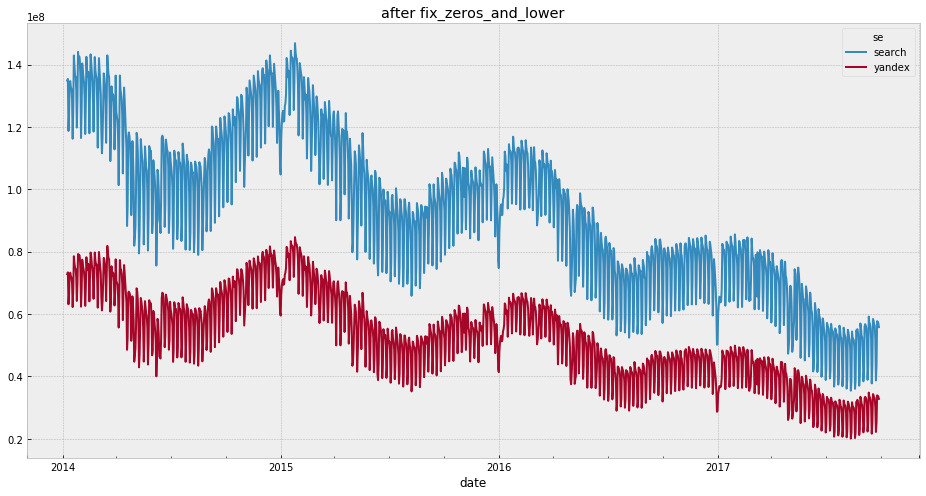

In [18]:
def fix_zeros_and_lower(df):
    df = df.copy()
    zday = parse(ZDAY)
    zleft, zright = parse(ZSPAN[0]), parse(ZSPAN[1])
    lleft, lright = parse(LSPAN[0]), parse(LSPAN[1])
    
    def past(d, days=1): return d - timedelta(days=days)
    def seek(d, days=1): return d + timedelta(days=days)
    
    for se, browser in product(SES, BROWSERS):
        cond = (df.se == se) & (df.browser == browser)
        
        prev_day = df.loc[cond & (df.date == past(zday)), 'hits'].values[0]
        next_day = df.loc[cond & (df.date == seek(zday)), 'hits'].values[0]
        df.loc[cond & (df.date == zday), 'hits'] = (prev_day + next_day) // 2
        
        nleft, nright = seek(zleft, days=365), seek(zright, days=365)
        zleft_val = df.loc[cond & (df.date == past(zleft)), 'hits'].values[0]
        nleft_val = df.loc[cond & (df.date == past(nleft)), 'hits'].values[0]
        nspan = df.loc[cond & (nleft <= df.date) & (df.date <= nright), 'hits'].values
        df.loc[cond & (zleft <= df.date) & (df.date <= zright), 'hits'] = nspan - nleft_val + zleft_val
        
        nvalues = df.loc[cond & (seek(lleft, days=7) <= df.date) & (df.date <= seek(lright, days=7)), 'hits']
        df.loc[cond & (lleft <= df.date) & (df.date <= lright), 'hits'] = nvalues.values

    return df


plot_fix(fix_zeros_and_lower, df, 'se')

In [19]:
old_df = df
df = fix_zeros_and_lower(df)

### Разрез `browser`

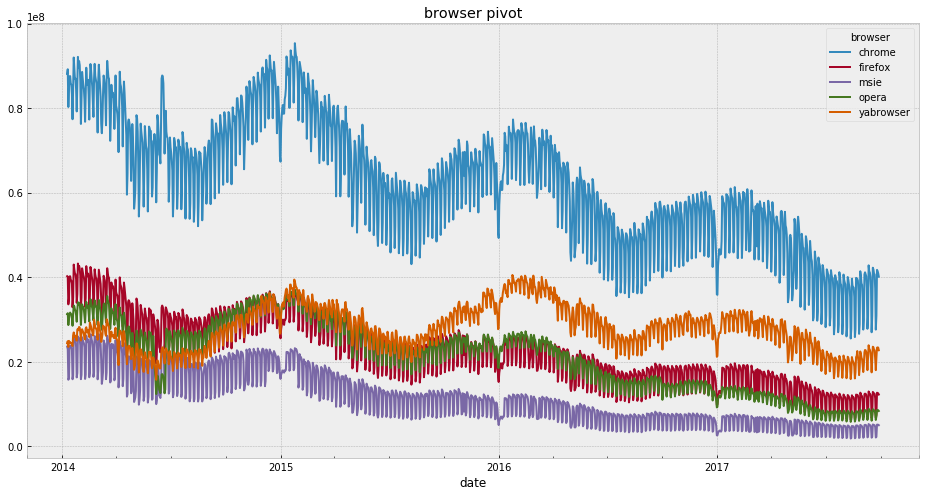

In [20]:
plot_pivot(df, 'browser')

Все ок, кроме спайка у хрома и оперы в серединке между 2014 и 2015. Посмотрим поближе.

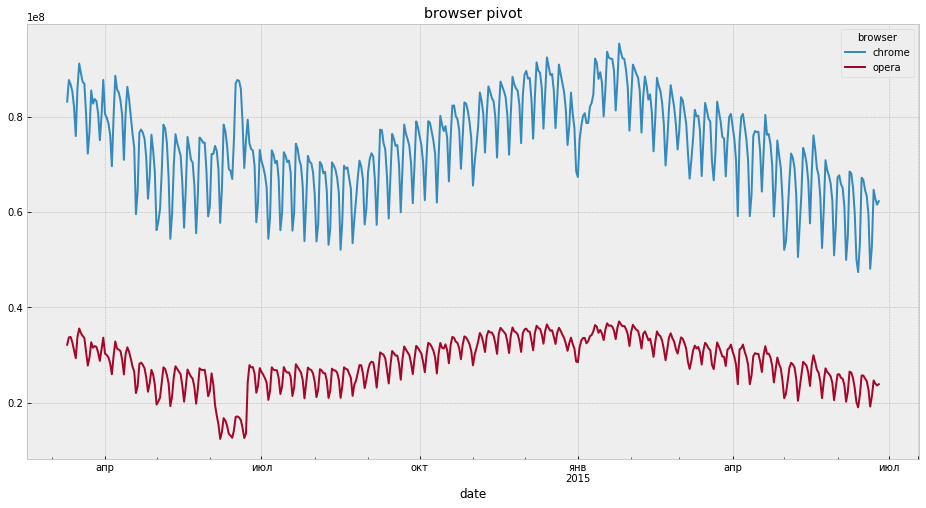

In [21]:
span = ('2014-03-10' <= df.date) & (df.date <= '2015-06-25')
cond = span & ((df.browser == 'opera') | (df.browser == 'chrome'))
plot_pivot(df[cond], 'browser')

Напишем фикс, значения подберем эмпирически.

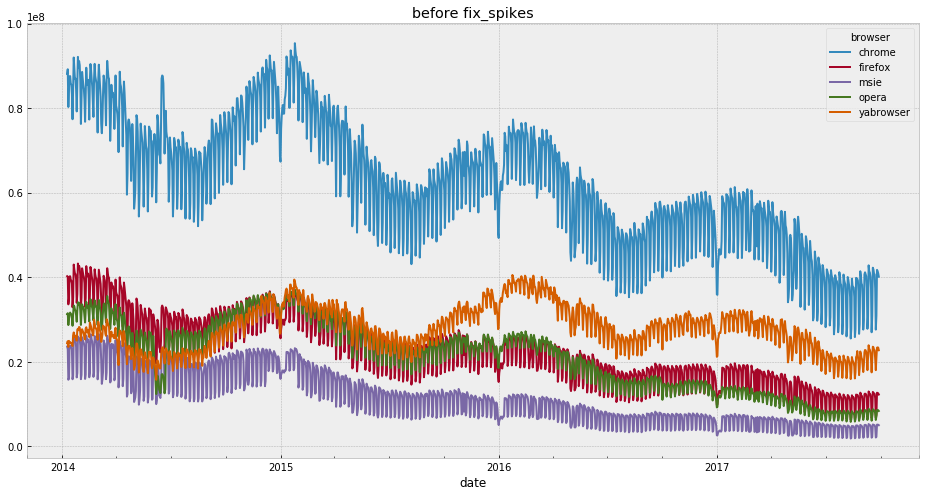

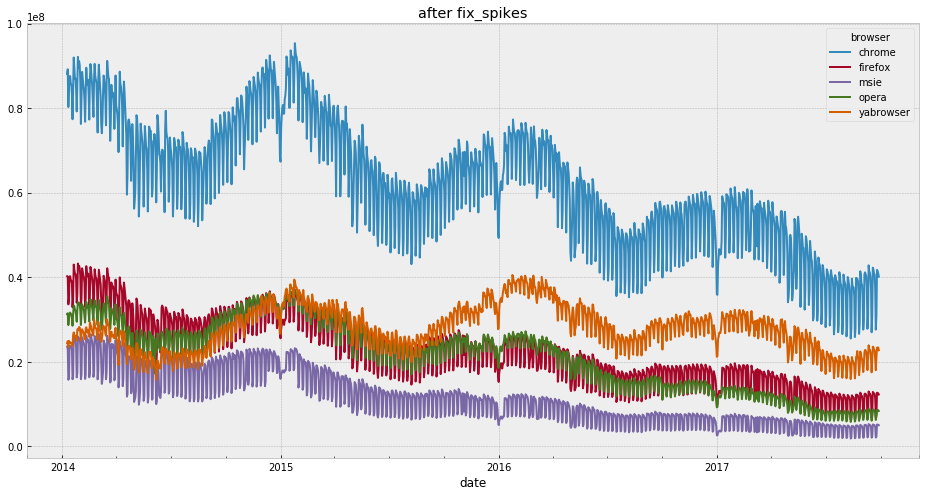

In [22]:
SSPAN = '2014-06-15', '2014-06-21'
OSPAN = '2014-06-06', '2014-06-22'


def fix_spikes(df):
    df = df.copy()
    sleft, sright = parse(SSPAN[0]), parse(SSPAN[1])
    oleft, oright = parse(OSPAN[0]), parse(OSPAN[1])
    
    def past(d, days=1): return d - timedelta(days=days)
    def seek(d, days=1): return d + timedelta(days=days)
    
    for se in SES:
        cond = (df.se == se) & (df.browser == 'chrome')
        df.loc[cond & (sleft <= df.date) & (df.date <= sright), 'hits'] *= 0.8
    
    for se in SES:
        cond = (df.se == se) & (df.browser == 'opera')
        df.loc[cond & (oleft <= df.date) & (df.date <= oright), 'hits'] += (1e+7 / 2)
    
    return df


plot_fix(fix_spikes, df, 'browser')

Good. Еще раз посмотрим на оба среза.

In [23]:
df = fix_spikes(df)

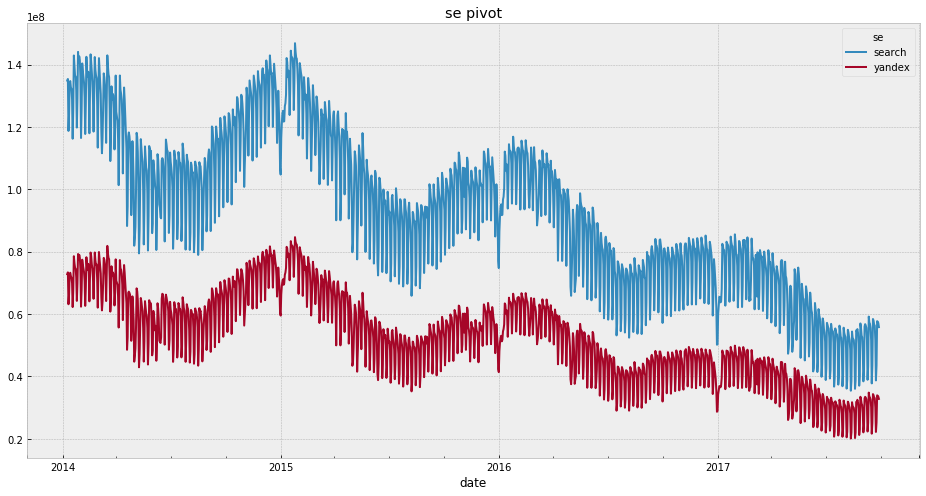

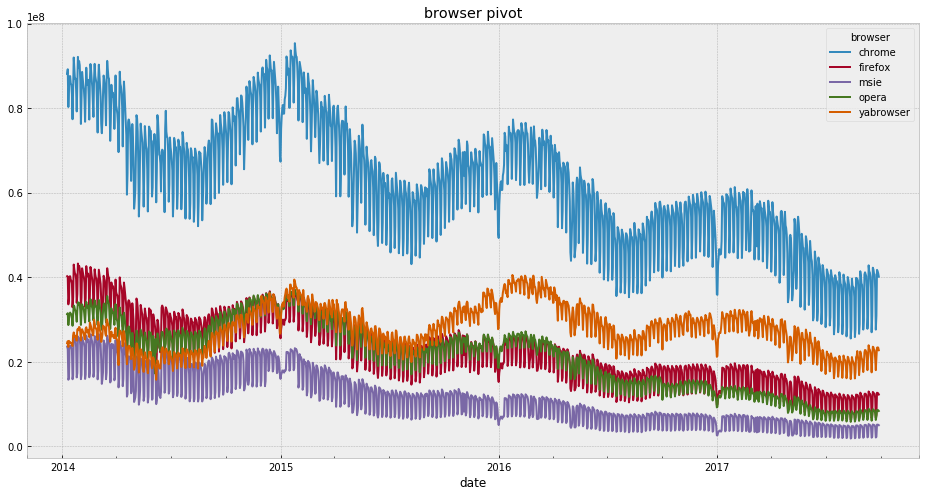

In [24]:
plot_pivot(df, 'se')
plot_pivot(df, 'browser')

Все ок. Остальные всплески очень похожи на сезонные явления.

In [25]:
old_df['hits_fixed'] = np.round(df.hits)
df = old_df

## STL

In [26]:
bind(pd.DataFrame, stldf)
bind(pd.Series, stl, forecast)

new_columns = ['hits_week_trend', 'hits_week_seasonal', 'hits_year_trend', 'hits_year_seasonal']
for column in new_columns:
    df[column] = np.zeros(len(df))

for se, browser in product(SES, BROWSERS):
    cond = (df.se == se) & (df.browser == browser)
    
    ts = pd.Series(df.loc[cond, 'hits_fixed'].tolist(), index=df.loc[cond, 'date'])
    res = ts.stl(frequency=7, method='arima')
    trend = res.iloc[:, 1].as_matrix()
    seasonal = (res.iloc[:, 0] + res.iloc[:, 1]).as_matrix()
    df.loc[cond, 'hits_week_trend'] = np.round(trend)
    df.loc[cond, 'hits_week_seasonal'] = np.round(seasonal)
    
    ts = pd.Series(trend, index=df.loc[cond, 'date'])
    res = ts.stl(frequency=365, method='arima')
    trend = res.iloc[:, 1].as_matrix()
    seasonal = (res.iloc[:, 0] + res.iloc[:, 1]).as_matrix()
    df.loc[cond, 'hits_year_trend'] = np.round(trend)
    df.loc[cond, 'hits_year_seasonal'] = np.round(seasonal)

Посмотрим на снятие недельной сезонности.

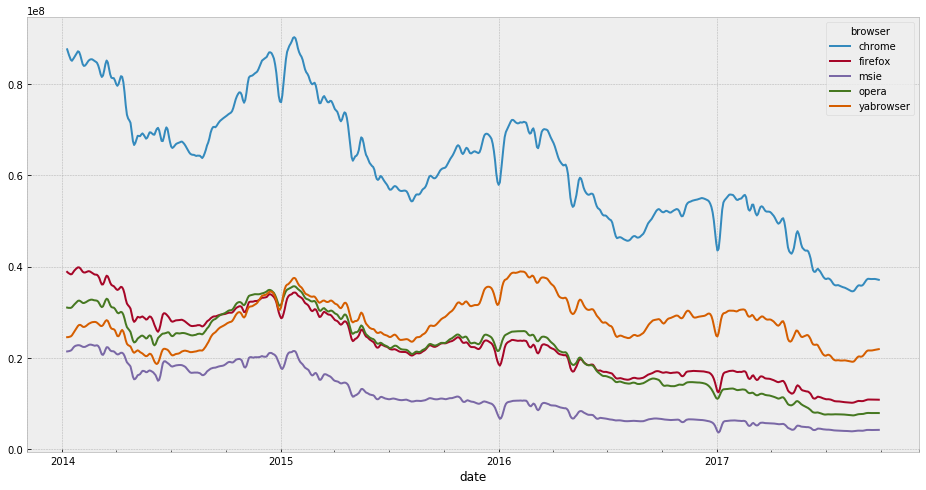

In [27]:
df.pivot_table(index='date', values='hits_week_trend', columns='browser', aggfunc=np.sum).plot()

Сохраним результат в csv.

In [28]:
df.to_csv('clean_data.csv', index=False)